<a href="https://colab.research.google.com/github/tomonari-masada/course2024-sml/blob/main/12_dimensionality_reduction_(advanced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction （発展編）

* GPUが使えるようにランタイムを設定しておく。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

np.random.seed(0)
torch.manual_seed(0)

%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv('/content/drive/MyDrive/data/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/sign_mnist_test.csv')

In [3]:
# Setting the label and the feature columns
y_train = train.loc[:,'label'].values
X_train = train.loc[:,'pixel1':].values
y_test = test.loc[:,'label'].values
X_test = test.loc[:,'pixel1':].values

## データの前処理
* scikit-learnのドキュメンテーションにあるやり方に倣った。
  * まずtraining set全体での各ピクセルの平均値を引き算し・・・
  * 次に各画像内でのローカルな平均値を引き算する。

In [4]:
# global centering
train_mean = X_train.mean(axis=0)
X_train_centered = X_train - train_mean
X_test_centered = X_test - train_mean

In [5]:
# local centering
X_train_centered -= X_train_centered.mean(axis=1).reshape(-1, 1)
X_test_centered -= X_test_centered.mean(axis=1).reshape(-1, 1)

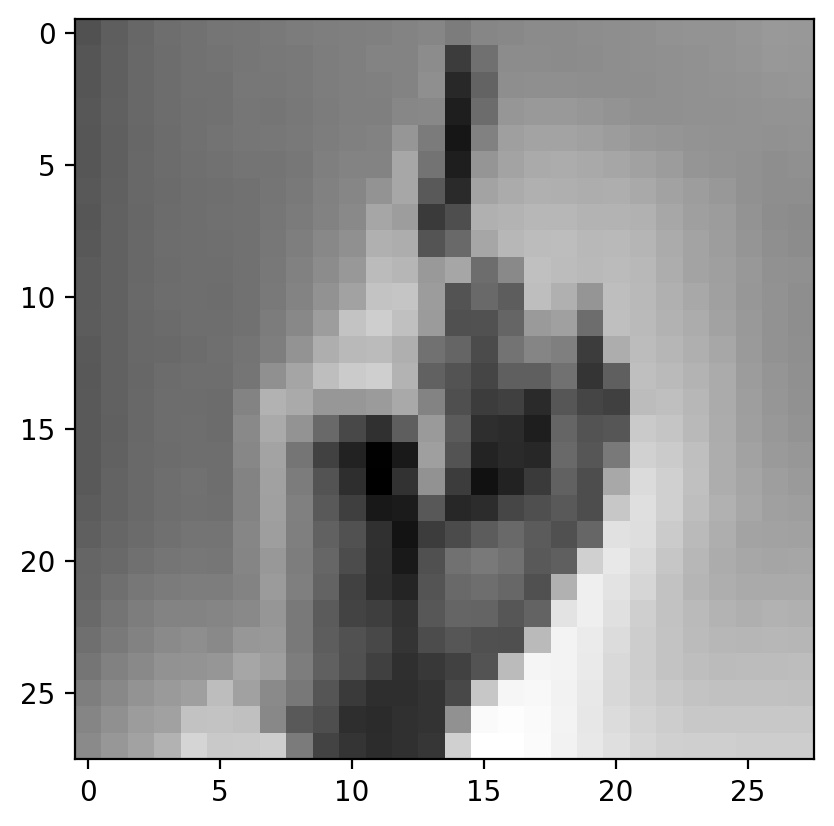

In [6]:
plt.imshow(X_train_centered[0,:].reshape(28,28), cmap=plt.cm.gray);

## 次元圧縮手法によるデータの再構成(reconstruction)

* 画像を複数描画する関数を定義しておく。

In [7]:
def plot_gallery(title, images, n_col=3, n_row=3, cmap=plt.cm.gray):
  plt.figure(figsize=(2. * n_col, 2.26 * n_row))
  plt.suptitle(title, size=16)
  for i, comp in enumerate(images):
    plt.subplot(n_row, n_col, i + 1)
    vmax = max(comp.max(), -comp.min())
    plt.imshow(
        comp.reshape(28, 28),
        cmap=cmap,
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
    )
    plt.xticks([])
    plt.yticks([])
  plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.);

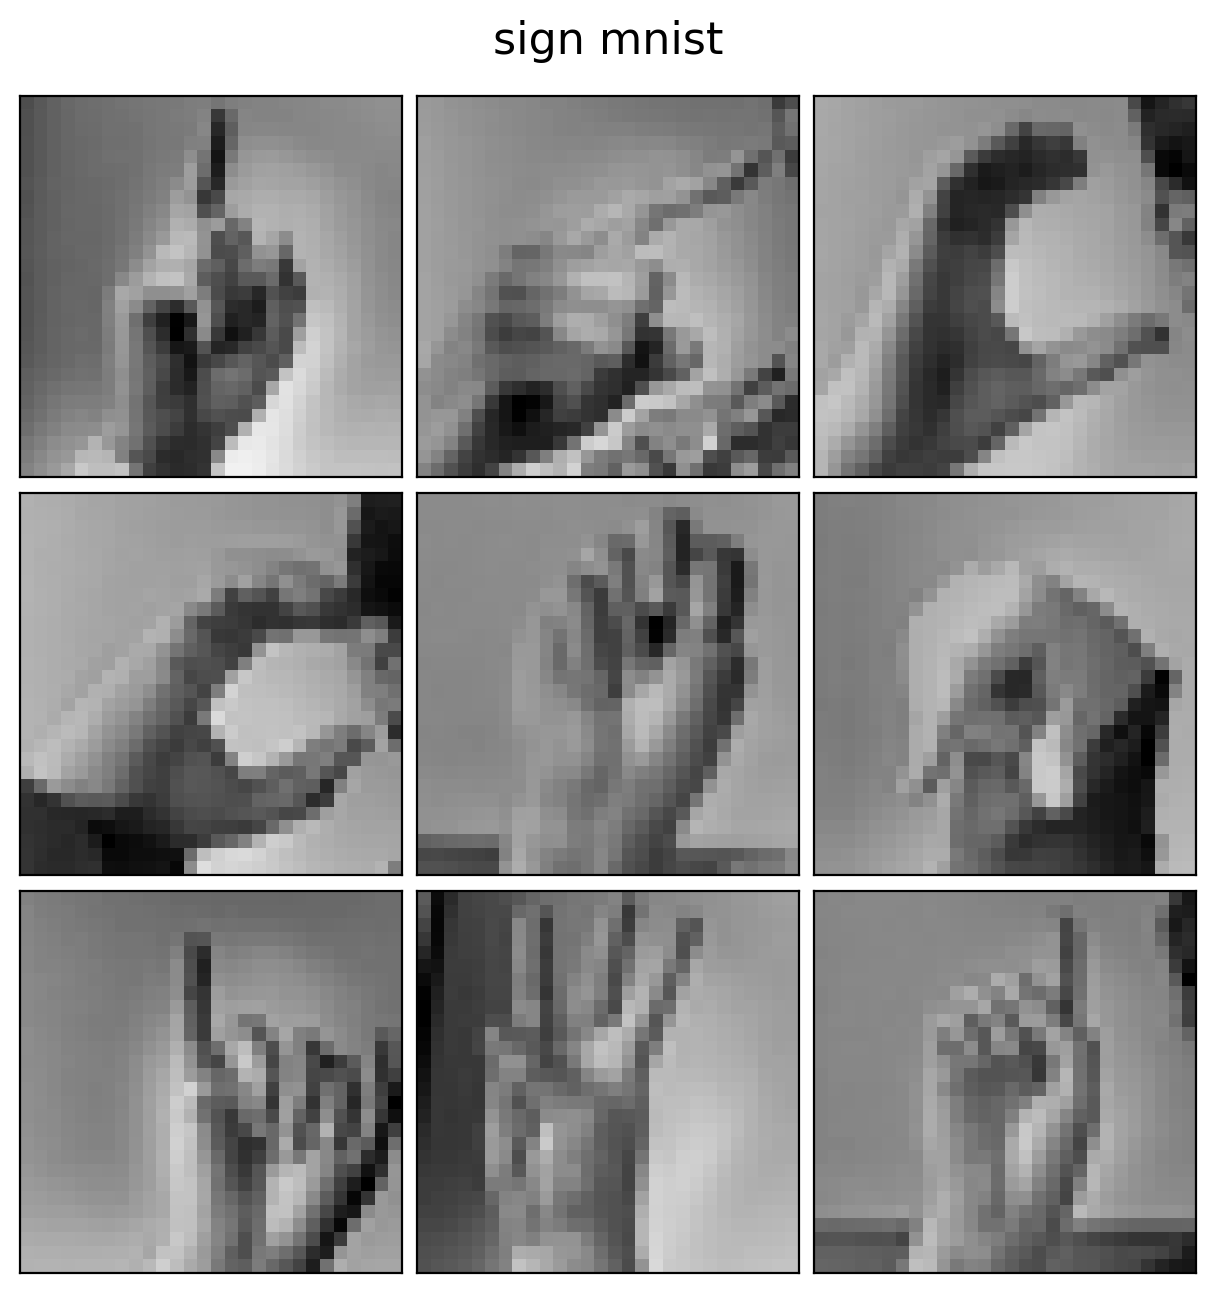

In [8]:
plot_gallery("sign mnist", X_train_centered[:9], n_row=3, n_col=3)

In [9]:
n_components = 30
n_instances, instance_dim = X_train_centered.shape
n_test_instances = X_test_centered.shape[0]

In [10]:
X_train_torch = torch.tensor(X_train_centered, dtype=torch.float, device="cuda")

bases = torch.randn((n_components, instance_dim), requires_grad=True, device="cuda")
coefficients = torch.randn((n_instances, n_components), requires_grad=True, device="cuda")

optimizer = torch.optim.Adam([bases, coefficients], lr=0.01)
criterion = torch.nn.MSELoss()

batch_size = 1000
n_steps = 0
for epoch in range(1000):
  random_indices = torch.randperm(n_instances)
  for i in range(0, n_instances, batch_size):
    indices = random_indices[i:i+batch_size]
    optimizer.zero_grad()
    reconstruction = torch.softmax(coefficients[indices], dim=1) @ bases
    loss = criterion(reconstruction, X_train_torch[indices])
    loss.backward()
    optimizer.step()
    n_steps += 1
    if n_steps % 1000 == 0:
      print(f"step {n_steps} | loss {loss.item():.4f}")

step 1000 | loss 1275.1960
step 2000 | loss 1039.1160
step 3000 | loss 912.2354
step 4000 | loss 850.4651
step 5000 | loss 774.7111
step 6000 | loss 731.3215
step 7000 | loss 658.6080
step 8000 | loss 648.9099
step 9000 | loss 625.2130
step 10000 | loss 609.6154
step 11000 | loss 591.0695
step 12000 | loss 556.2958
step 13000 | loss 556.6896
step 14000 | loss 543.1186
step 15000 | loss 533.0295
step 16000 | loss 520.8922
step 17000 | loss 505.3629
step 18000 | loss 481.5125
step 19000 | loss 476.8735
step 20000 | loss 481.9387
step 21000 | loss 491.8810
step 22000 | loss 453.8468
step 23000 | loss 463.1695
step 24000 | loss 452.1045
step 25000 | loss 442.8857
step 26000 | loss 447.8730
step 27000 | loss 446.6423
step 28000 | loss 438.9588


In [11]:
components = bases.cpu().detach().numpy()

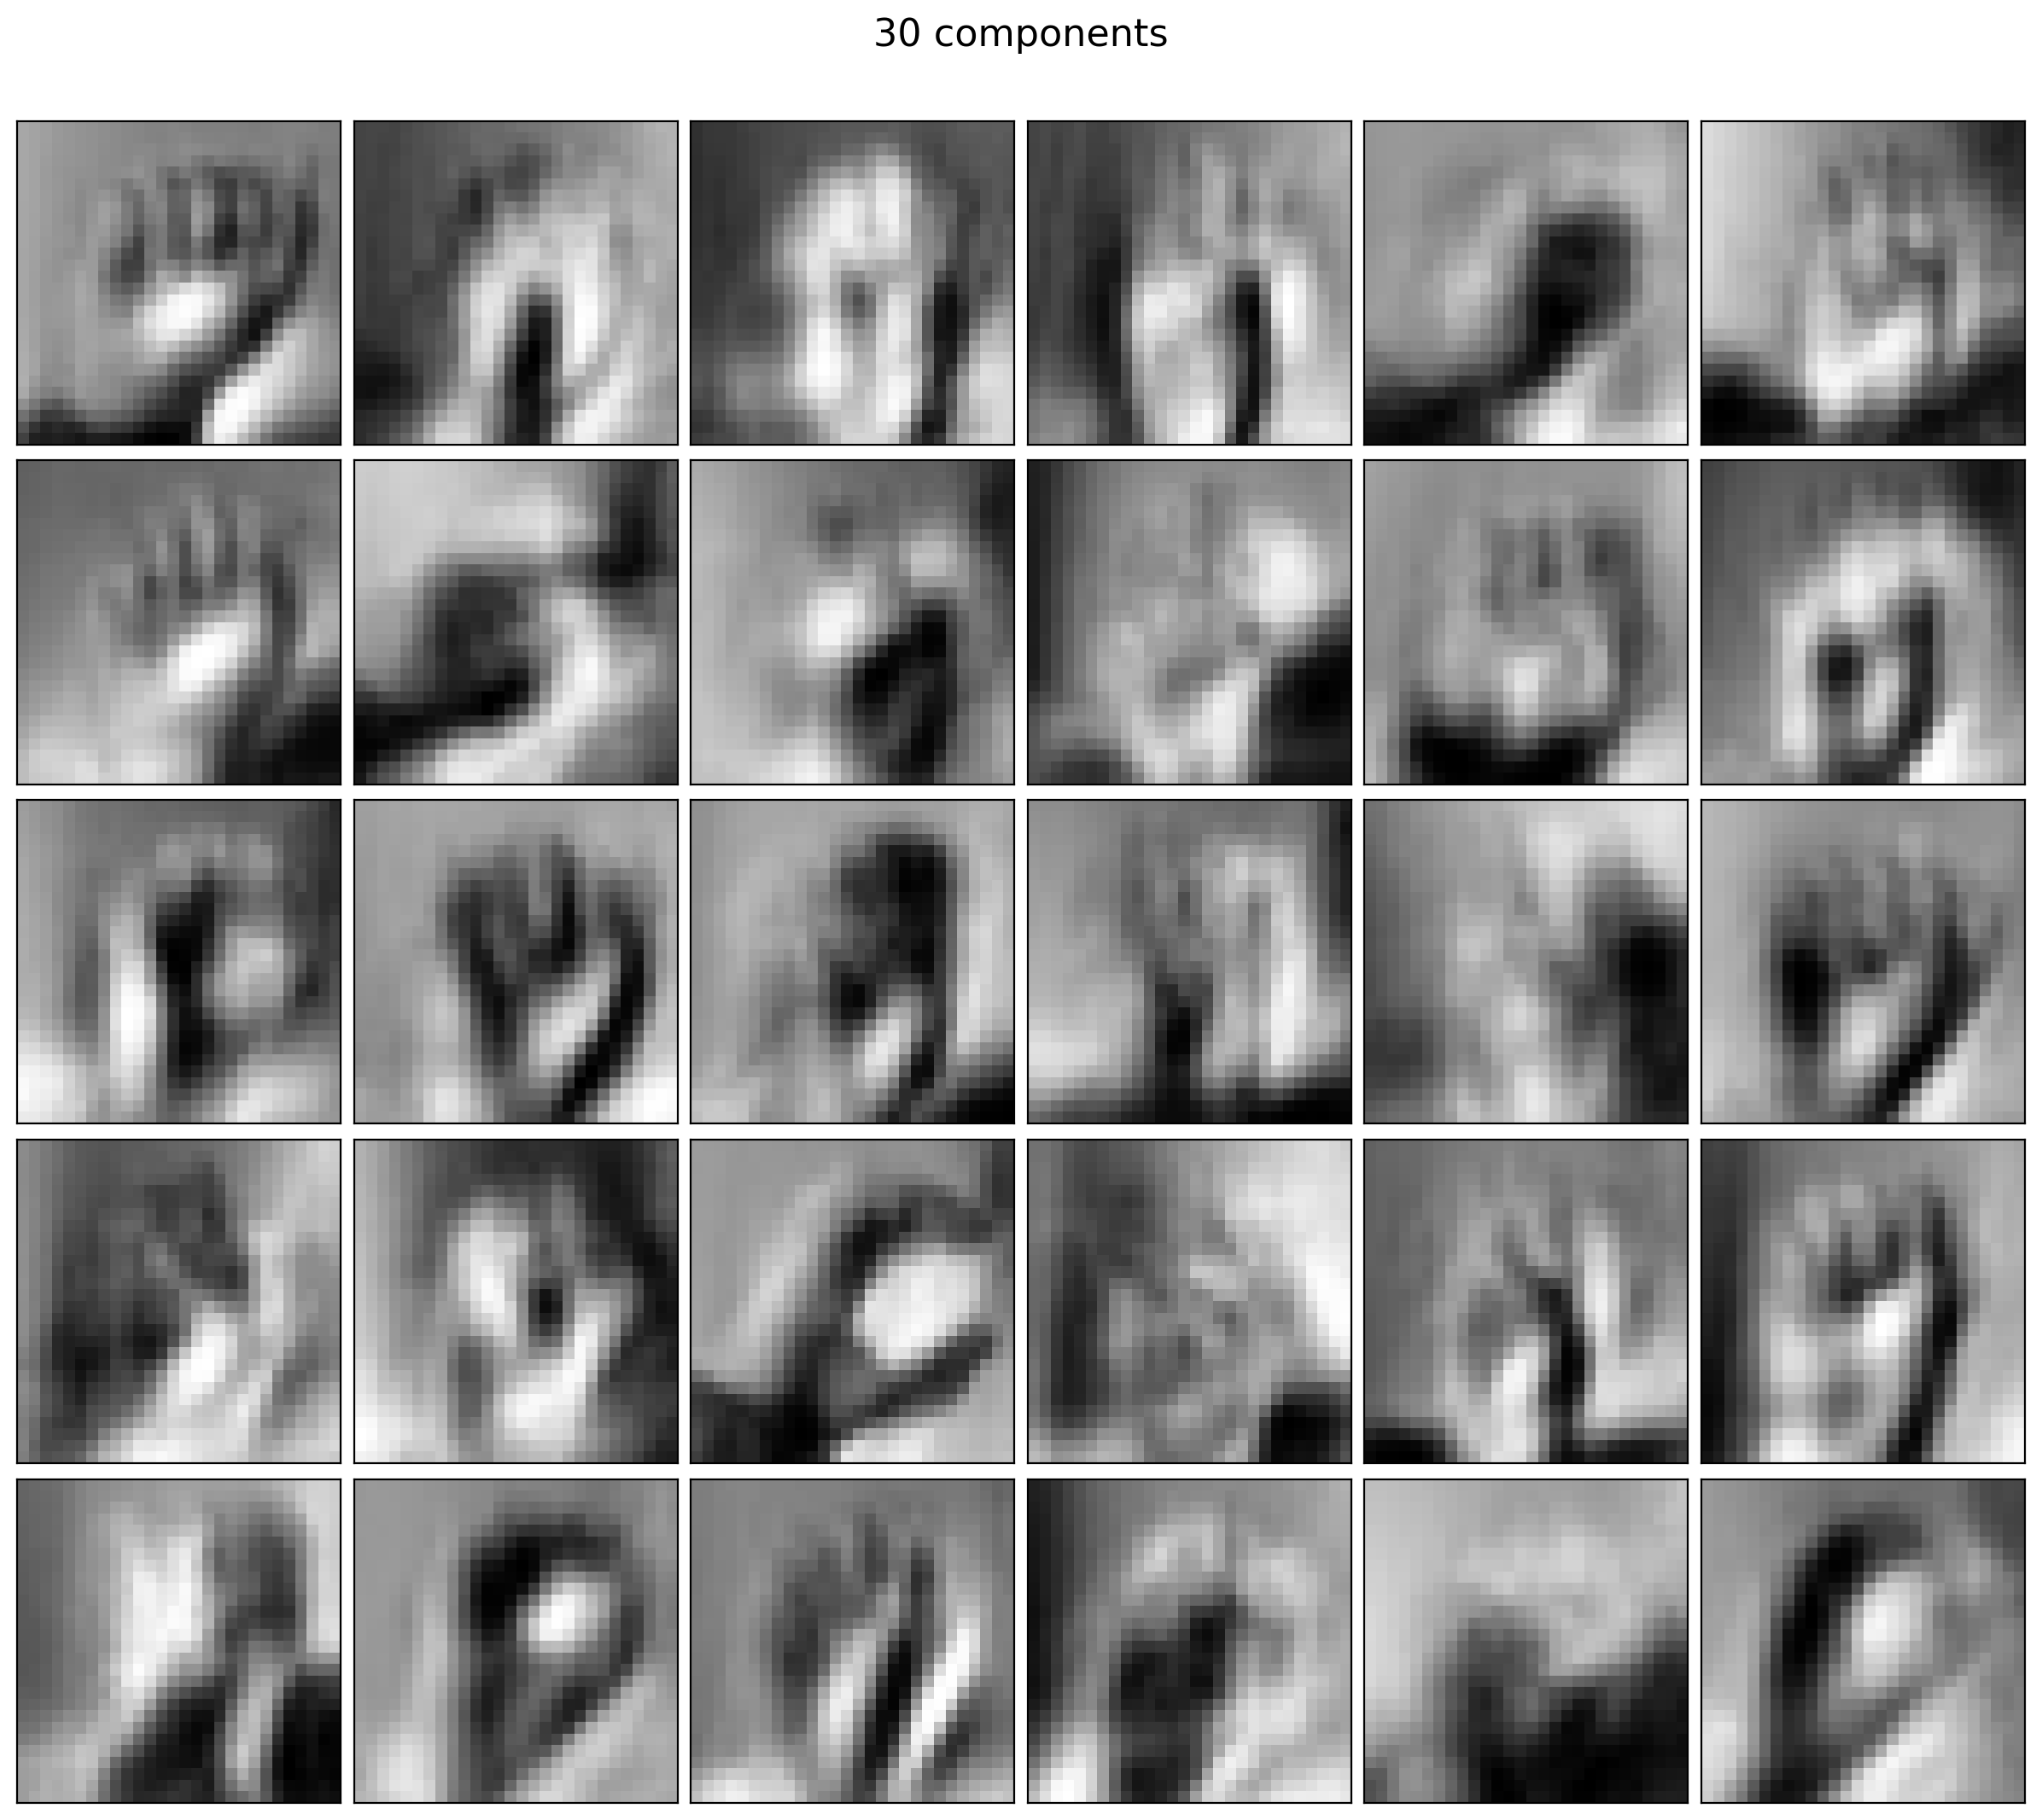

In [12]:
n_col = 6
n_row = n_components // n_col + (n_components % n_col != 0)
plot_gallery(
    f"{n_components} components",
    components[:n_components],
    n_row=n_row,
    n_col=n_col,
)

### テストセットに含まれる画像の再構成

In [13]:
X_test_torch = torch.tensor(X_test_centered, dtype=torch.float, device="cuda")

bases.requires_grad = False
coefficients = torch.randn((n_test_instances, n_components), requires_grad=True, device="cuda")

optimizer = torch.optim.Adam([coefficients], lr=0.01)
criterion = torch.nn.MSELoss()

batch_size = 1000
n_steps = 0
for epoch in range(1000):
  random_indices = torch.randperm(n_test_instances)
  for i in range(0, n_test_instances, batch_size):
    indices = random_indices[i:i+batch_size]
    optimizer.zero_grad()
    reconstruction = torch.softmax(coefficients[indices], dim=1) @ bases
    loss = criterion(reconstruction, X_test_torch[indices])
    loss.backward()
    optimizer.step()
    n_steps += 1
    if n_steps % 1000 == 0:
      print(f"step {n_steps} | test reconstruction loss {loss.item():.4f}")

step 1000 | test reconstruction loss 476.6719
step 2000 | test reconstruction loss 454.0465
step 3000 | test reconstruction loss 473.0758
step 4000 | test reconstruction loss 476.4247
step 5000 | test reconstruction loss 497.4348
step 6000 | test reconstruction loss 443.4250
step 7000 | test reconstruction loss 436.8242
step 8000 | test reconstruction loss 417.1192


In [14]:
X_test_recon = (torch.softmax(coefficients, dim=1) @ bases).cpu().detach().numpy()

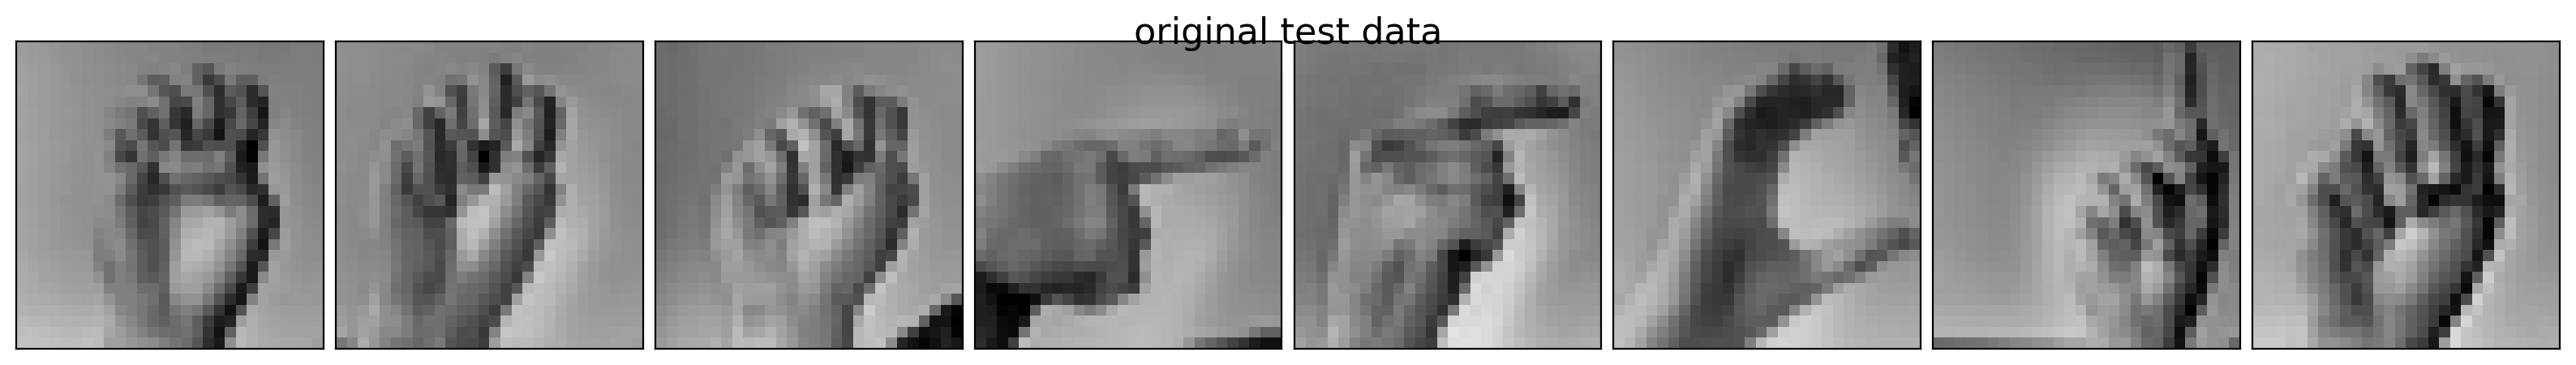

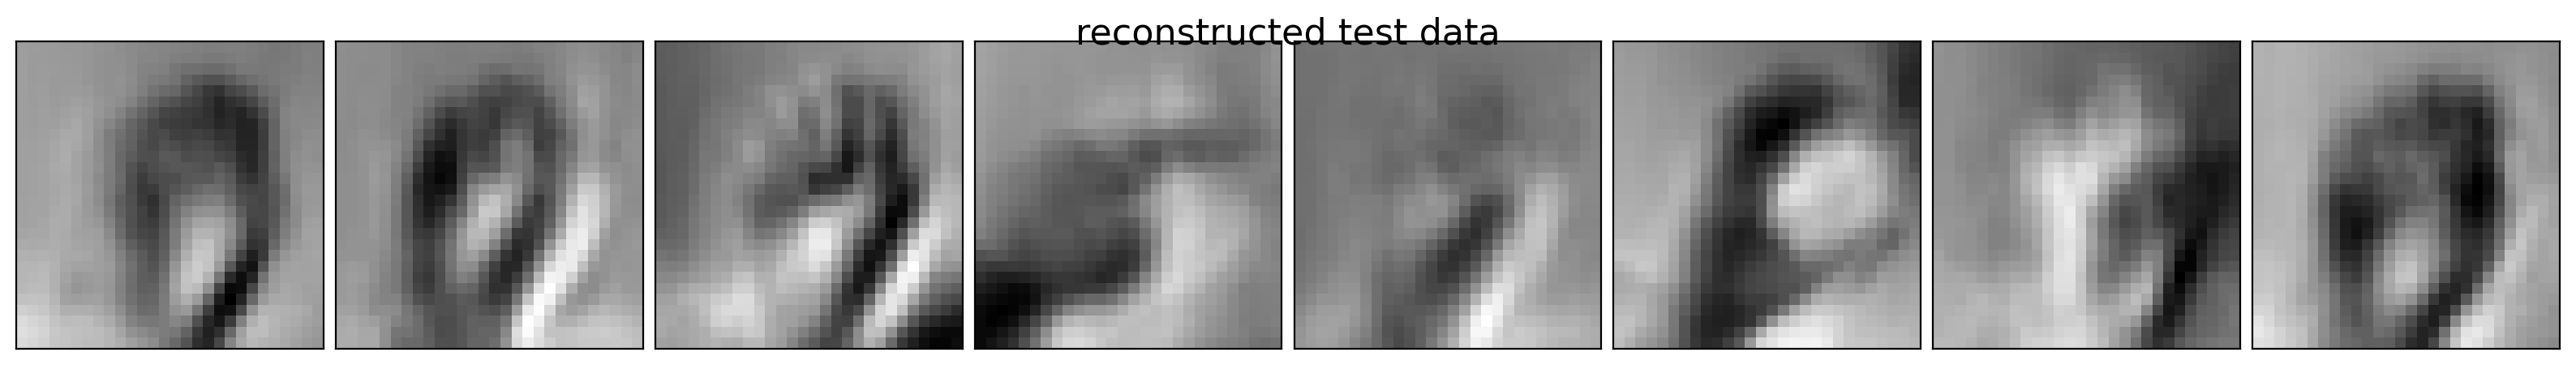

In [15]:
n_recon_images = 8
indices = np.random.randint(X_test.shape[0], size=n_recon_images)
plot_gallery("original test data", X_test_centered[indices], n_row=1, n_col=n_recon_images)
plot_gallery("reconstructed test data", X_test_recon[indices], n_row=1, n_col=n_recon_images)